In [61]:
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
from itertools import combinations
import numpy as np
from collections import defaultdict
from statsmodels.distributions.empirical_distribution import ECDF
import json
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns
import community.community_louvain as community_louvain

In [62]:
# Canali target da cui raccogliere i video
canali = [
    "Fanpage.it",
    "La Repubblica",
    "FABRIZIO CORONA",
    "Gianmarco Zagato",
    "La7 Attualità",
    "Rai",
    "Bugalalla Crime",
    "DarkSide - Storia Segreta d'Italia"
]

# Intervallo temporale per i video (due settimana prima dalla riapertura del caso fino ai giorni odierni)
begin_date = datetime(2025, 2, 25)
end_date = datetime(2025, 6, 8)

In [63]:
# Crea struttura Comment
class Comment:
    def __init__(self, id, video_id, content, author, date, likes, reply_to_id=None):
        self.id = id
        self.video_id = video_id
        self.content = content
        self.author = author
        self.date = date
        self.likes = int(likes)
        self.reply_to_id = reply_to_id

    def __repr__(self):
        return f"<Comment by {self.author} on {self.date.strftime('%Y-%m-%d')}>"


In [64]:
with open("./comments.json", "r", encoding="utf-8") as f:
    comments = json.load(f)

with open("./videos.json", "r", encoding="utf-8") as f:
    videos = json.load(f)

with open("./videos_with_views.json", "r", encoding="utf-8") as f:
    videos_with_views = json.load(f)

In [84]:
# Strutture dati utilizzabili per l'analisi
# Mappa video_id → canale
Channel_of = {v["video_id"]: v["channel"] for v in videos}

# Mappa canale → lista video_id
Videos_of = defaultdict(list)
for v in videos:
    Videos_of[v["channel"]].append(v["video_id"])

# Mappa video_id → data
Date_of_video = {v["video_id"]: v["published_at"] for v in videos}

# Mappa video_id → views
Video_to_views = {v["video_id"]: v["viewCount"] for v in videos_with_views}

# Mappa video_id → like
Video_to_likes = {v["video_id"]: v.get("likeCount", 0) for v in videos_with_views}

# Inizializza dizionari ausiliari
Commenters_of_video = defaultdict(set)
Videos_commented_by = defaultdict(set)
Channels_commented_by = defaultdict(set)
Commenters_of_channel = defaultdict(set)
Comments_of_channel = defaultdict(list)
Comments_by_user = defaultdict(list)

# Popola strutture dai commenti
for c in comments:
    video_id = c["video_id"]
    author = c["author"]
    channel = Channel_of.get(video_id, "Unknown")

    comment_obj = Comment(
        id=c["comment_id"],
        video_id=video_id,
        content=c["content"],
        author=author,
        date=c["date"],
        likes=c["likes"],
        reply_to_id=c.get("reply_to_id")
    )

    Commenters_of_video[video_id].add(author)
    Videos_commented_by[author].add(video_id)
    Channels_commented_by[author].add(channel)
    Commenters_of_channel[channel].add(author)
    Comments_of_channel[channel].append(comment_obj)
    Comments_by_user[author].append(comment_obj)

# Mappa comment_id → autore
author_of_comment = {}
for user_comments in Comments_by_user.values():
    for comment in user_comments:
        author_of_comment[comment.id] = comment.author

# Debug: stampa sommaria
print(f"Video totali: {len(Channel_of)}")
print(f"Utenti unici: {len(Comments_by_user)}")
print(f"Canali totali: {len(Videos_of)}")
print(f"Commenti totali: {len(comments)}")


Video totali: 239
Utenti unici: 24824
Canali totali: 8
Commenti totali: 111104


In [66]:
# Grafo utente-utente
utente_utente_G = nx.Graph()
edge_weights = defaultdict(int)

user_comment_count = {user: len(Comments_by_user[user]) for user in Comments_by_user}
active_users = {user for user, count in user_comment_count.items() if count >= 5}

for video_id, commenters in Commenters_of_video.items():
    commenters = [u for u in commenters if u in active_users]
    if len(commenters) < 2:
        continue
    for u1, u2 in combinations(commenters, 2):
        if u1 and u2:
            edge = tuple(sorted([u1, u2]))
            edge_weights[edge] += 1

for (u1, u2), weight in edge_weights.items():
    if weight >= 3:  
        utente_utente_G.add_edge(u1, u2, weight=weight)

for user in utente_utente_G.nodes:
    num_videos = len(Videos_commented_by.get(user, set()))
    utente_utente_G.nodes[user]["video_count"] = num_videos

In [67]:
nx.write_gexf(utente_utente_G, "rete_utente_utente.gexf")

In [68]:
isolati = [n for n in utente_utente_G.nodes if utente_utente_G.degree(n) == 0]
utente_utente_G.remove_nodes_from(isolati)

In [69]:
for user in utente_utente_G.nodes:
    utente_utente_G.nodes[user]['comment_count'] = len(Comments_by_user.get(user, []))
    utente_utente_G.nodes[user]['channels_commented'] = len(Channels_commented_by.get(user, set()))
    print(f"Utente: {user}, Video: {utente_utente_G.nodes[user]['video_count']}, Commenti: {utente_utente_G.nodes[user]['comment_count']}, Canali: {utente_utente_G.nodes[user]['channels_commented']}")

Utente: @francescodemonte4420, Video: 12, Commenti: 18, Canali: 6
Utente: @pelagica1, Video: 35, Commenti: 123, Canali: 5
Utente: @marcopilati7464, Video: 50, Commenti: 58, Canali: 6
Utente: @angelagiovanna4757, Video: 19, Commenti: 26, Canali: 6
Utente: @eddifiori2598, Video: 20, Commenti: 51, Canali: 4
Utente: @Riccardo6994, Video: 46, Commenti: 59, Canali: 6
Utente: @silviamaga5740, Video: 37, Commenti: 53, Canali: 5
Utente: @cinigliango7117, Video: 26, Commenti: 46, Canali: 5
Utente: @LuLu-ho1xq, Video: 11, Commenti: 15, Canali: 5
Utente: @italiaitalia3424, Video: 10, Commenti: 13, Canali: 5
Utente: @PatriziaZaki-y4x, Video: 11, Commenti: 15, Canali: 4
Utente: @gisascoscina3881, Video: 18, Commenti: 24, Canali: 4
Utente: @tommasodisa8516, Video: 28, Commenti: 41, Canali: 4
Utente: @DeepDarkSpiral, Video: 7, Commenti: 7, Canali: 4
Utente: @Bianca.Castafiore, Video: 33, Commenti: 127, Canali: 5
Utente: @filger65, Video: 23, Commenti: 63, Canali: 5
Utente: @violetabuca1109, Video: 25,

In [70]:
# Calcolo delle statistiche per il grafo utente-utente
num_nodi_utenti = utente_utente_G.number_of_nodes()
num_archi_utenti = utente_utente_G.number_of_edges()
print(f"\n=== Statistiche Generiche ===")
print(f"Numero di nodi (utenti): {num_nodi_utenti}")
print(f"Numero di archi: {num_archi_utenti}")

densita_utenti = nx.density(utente_utente_G)
print(f"Densità del grafo: {densita_utenti:.4f}")

gradi_utenti = [d for n, d in utente_utente_G.degree()]
print(f"Grado medio: {np.mean(gradi_utenti):.2f}")
print(f"Grado mediano: {np.median(gradi_utenti)}")
print(f"Grado minimo: {np.min(gradi_utenti)}")
print(f"Grado massimo: {np.max(gradi_utenti)}")

video_counts = [utente_utente_G.nodes[n].get('video_count', 0) for n in utente_utente_G.nodes]
print(f"\n=== Statistiche Numero Video Commentati per Utente ===")
print(f"Media: {np.mean(video_counts):.2f}")
print(f"Mediana: {np.median(video_counts):.0f}")
print(f"Deviazione standard: {np.std(video_counts):.2f}")
print(f"Min: {np.min(video_counts)}")
print(f"Max: {np.max(video_counts)}")

jaccard_similarities = []
for u, v in utente_utente_G.edges():
    set_u = Videos_commented_by.get(u, set())
    set_v = Videos_commented_by.get(v, set())
    intersection = len(set_u & set_v)
    union = len(set_u | set_v)
    jaccard = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard)

print(f"\n=== Statistiche Similarità Jaccard ===")
if jaccard_similarities:
    print(f"Media: {np.mean(jaccard_similarities):.4f}")
    print(f"Mediana: {np.median(jaccard_similarities):.4f}")
    print(f"Deviazione standard: {np.std(jaccard_similarities):.4f}")
    print(f"Min: {np.min(jaccard_similarities):.4f}")
    print(f"Max: {np.max(jaccard_similarities):.4f}")
else:
    print("Nessuna similarità Jaccard calcolabile (nessun arco nel grafo).")


=== Statistiche Generiche ===
Numero di nodi (utenti): 4362
Numero di archi: 1021897
Densità del grafo: 0.1074
Grado medio: 468.55
Grado mediano: 248.0
Grado minimo: 1
Grado massimo: 3862

=== Statistiche Numero Video Commentati per Utente ===
Media: 9.50
Mediana: 7
Deviazione standard: 8.57
Min: 3
Max: 112

=== Statistiche Similarità Jaccard ===
Media: 0.1557
Mediana: 0.1429
Deviazione standard: 0.0741
Min: 0.0240
Max: 1.0000


In [71]:
partition = community_louvain.best_partition(utente_utente_G)
modularity = community_louvain.modularity(partition, utente_utente_G)
print(f"\n=== Modularità della partizione ===")
print(f"Modularità: {modularity:.4f}")


=== Modularità della partizione ===
Modularità: 0.1360


In [72]:
# Strutture ausiliarie
community_to_users = defaultdict(set)
for user, comm in partition.items():
    community_to_users[comm].add(user)

community_to_channels = defaultdict(set)
for comm, users in community_to_users.items():
    for user in users:
        community_to_channels[comm].update(Channels_commented_by.get(user, set()))

In [105]:
utenti_multicanale_per_canale = {}
for canale in canali:
    utenti = Commenters_of_channel[canale]
    if utenti:
        multi = sum(1 for u in utenti if len(Channels_commented_by[u]) > 1)
        utenti_multicanale_per_canale[canale] = multi
    else:
        utenti_multicanale_per_canale[canale] = 0

community_of_user = {}
for comm, users in community_to_users.items():
    for u in users:
        community_of_user[u] = comm

N_MIN_REPLY = 2  
utenti_ponte = set()
community_collegate_da_utente = dict()
for user, commenti in Comments_by_user.items():
    comm_user = community_of_user.get(user)
    if comm_user is None:
        continue

    altre_community = set()
    for c in commenti:
        reply_to = c.reply_to_id
        if reply_to and reply_to in author_of_comment:
            replied_user = author_of_comment[reply_to]
            comm_replied = community_of_user.get(replied_user)
            if comm_replied is not None and comm_replied != comm_user:
                altre_community.add(comm_replied)
    if len(altre_community) >= N_MIN_REPLY:
        utenti_ponte.add(user)
        community_collegate_da_utente[user] = altre_community

In [106]:
for u, comms in community_collegate_da_utente.items():
    print(f"Utente {u} collega le community: {comms}")

Utente @elenaLB-p9z collega le community: {0, 1}
Utente @marcet482 collega le community: {0, 1}
Utente @francescodemonte4420 collega le community: {1, 2}
Utente @lauranelli5234 collega le community: {1, 2}
Utente @Riccardo6994 collega le community: {0, 1}
Utente @liberamente-jq1uf collega le community: {1, 2}
Utente @nessunodifamoso7072 collega le community: {1, 2}
Utente @AlbaRosso-lp7fb collega le community: {0, 1}
Utente @silvergiulia collega le community: {0, 1}
Utente @antoniotorcoli5740 collega le community: {0, 2}
Utente @FlamingJune68 collega le community: {0, 1}
Utente @maurizioostia8744 collega le community: {0, 1}
Utente @Bro-gs1mz collega le community: {0, 1}
Utente @Turetta-n3r collega le community: {0, 1}
Utente @AndreaCroveglia collega le community: {0, 1}
Utente @simonemilan919 collega le community: {0, 1}
Utente @TheClaudiano78 collega le community: {0, 1}
Utente @AnnaFumagalli-o6g collega le community: {1, 2}
Utente @Mamacita63-c3t collega le community: {0, 1}
Utente 

In [107]:
for comm in sorted(community_to_users):
    users = community_to_users[comm]
    channels = community_to_channels[comm]
    n_users = len(users)
    n_channels = len(channels)
    n_multi = sum(1 for u in users if len(Channels_commented_by.get(u, set())) > 1)
    n_ponte = sum(
        1 for u in users
        if u in utenti_ponte
    )
    print(f"\nCommunity {comm}:")
    print(f"  Utenti: {n_users}")
    print(f"  Canali commentati: {n_channels}")
    print(f"  Utenti multicanale: {n_multi}")
    print(f"  Utenti ponte: {n_ponte}")


Community 0:
  Utenti: 1161
  Canali commentati: 8
  Utenti multicanale: 913
  Utenti ponte: 223

Community 1:
  Utenti: 1304
  Canali commentati: 8
  Utenti multicanale: 934
  Utenti ponte: 292

Community 2:
  Utenti: 1897
  Canali commentati: 8
  Utenti multicanale: 1760
  Utenti ponte: 314


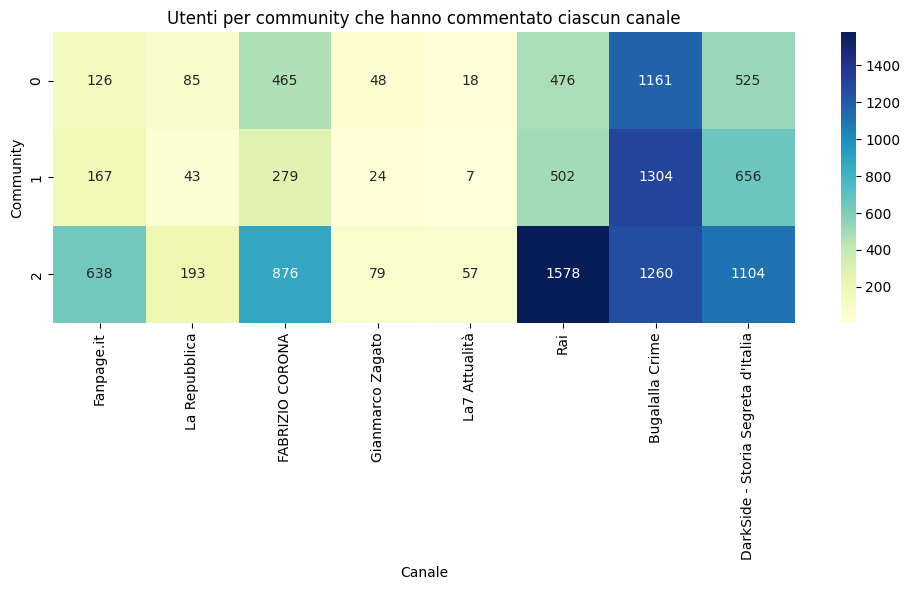

In [108]:
# 3. Matrice community-canale
mat_comm_canale = pd.DataFrame(
    0, index=sorted(community_to_users.keys()), columns=canali
)

for comm, users in community_to_users.items():
    for user in users:
        for ch in Channels_commented_by.get(user, []):
            if ch in canali:
                mat_comm_canale.loc[comm, ch] += 1


plt.figure(figsize=(10, 6))
sns.heatmap(mat_comm_canale, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Utenti per community che hanno commentato ciascun canale")
plt.xlabel("Canale")
plt.ylabel("Community")
plt.tight_layout()
plt.show()

In [123]:
utenti_ponte_per_canale = {}
utenti_totali_per_canale = {}
utenti_grafo = set(utente_utente_G.nodes)

for canale in canali:
    utenti_canale = Commenters_of_channel.get(canale, set())
    utenti_canale_grafo = utenti_canale & utenti_grafo  
    utenti_totali_per_canale[canale] = len(utenti_canale_grafo)
    utenti_ponte_per_canale[canale] = sum(1 for u in utenti_canale_grafo if u in utenti_ponte)

views_media = []
likes_media = []
for canale in canali:
    video_ids = Videos_of.get(canale, [])
    views = [Video_to_views.get(vid, 0) for vid in video_ids]
    likes = [Video_to_likes.get(vid, 0) for vid in video_ids]
    views_media.append(np.mean(views) if views else 0)
    likes_media.append(np.mean(likes) if likes else 0)

df_confronto = pd.DataFrame({
    "Canale": canali,
    "Utenti multicanale": [utenti_multicanale_per_canale.get(c, 0) for c in canali],
    "Utenti ponte tra community": [utenti_ponte_per_canale.get(c, 0) for c in canali],
    "Utenti totali": [utenti_totali_per_canale.get(c, 0) for c in canali],
    "Views_media": views_media,
    "Likes_media": likes_media
})

df_confronto = df_confronto.set_index("Canale")
df_confronto

,Utenti multicanale,Utenti ponte tra community,Utenti totali,Views_media,Likes_media
Canale,,,,,
Fanpage.it,1353,278,931,61295.894737,427.894737
La Repubblica,438,137,321,32651.555556,370.777778
FABRIZIO CORONA,2737,387,1620,930707.250000,23161.000000
Gianmarco Zagato,229,33,151,139173.750000,7726.500000
La7 Attualità,120,28,82,260345.500000,505.000000
Rai,4010,618,2556,67422.081818,390.263636
Bugalalla Crime,5029,766,3725,111006.118644,4006.033898
DarkSide - Storia Segreta d'Italia,3420,598,2285,106709.406250,2446.187500


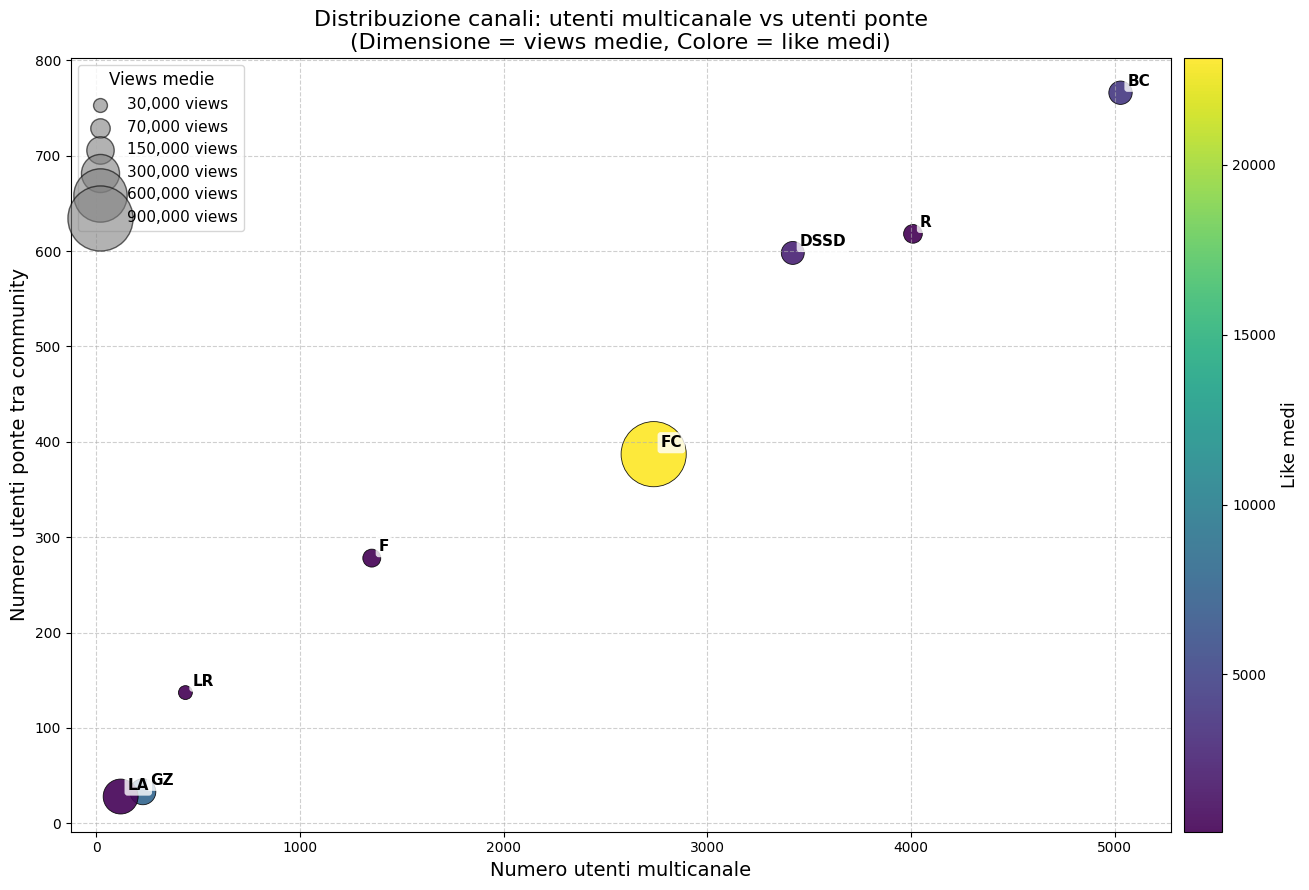

In [125]:
def normalize_sizes(values, min_size=100, max_size=2200):
    v = np.array(values)
    if v.max() == v.min():
        return np.full_like(v, (min_size + max_size) / 2)
    return min_size + (v - v.min()) / (v.max() - v.min()) * (max_size - min_size)

def abbrevia_nome(nome):
    return ''.join([w[0].upper() for w in nome.split() if w[0].isalnum()])

sizes = normalize_sizes(df_confronto["Views_media"])
colors = df_confronto["Likes_media"]
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(14, 9))
sc = ax.scatter(
    df_confronto["Utenti multicanale"],
    df_confronto["Utenti ponte tra community"],
    s=sizes,
    c=colors,
    cmap=cmap,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.6
)

for i, row in df_confronto.iterrows():
    abbreviazione = abbrevia_nome(i)
    ax.annotate(
        abbreviazione,
        (row["Utenti multicanale"], row["Utenti ponte tra community"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha='left',
        fontsize=11,
        weight='bold',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8, lw=0)
    )

ax.set_xlabel("Numero utenti multicanale", fontsize=14)
ax.set_ylabel("Numero utenti ponte tra community", fontsize=14)
ax.set_title(
    "Distribuzione canali: utenti multicanale vs utenti ponte\n(Dimensione = views medie, Colore = like medi)",
    fontsize=16
)

ax.grid(True, linestyle='--', alpha=0.6)
cbar = plt.colorbar(sc, ax=ax, pad=0.01)
cbar.set_label("Like medi", fontsize=13)

legend_views = [30000, 70000, 150000, 300000, 600000, 900000]
legend_s = normalize_sizes(np.array(legend_views))
legend_labels = [f"{v:,} views" for v in legend_views]
legend_handles = [
    plt.scatter([], [], s=s, color='gray', alpha=0.6, edgecolor='black', label=l)
    for s, l in zip(legend_s, legend_labels)
]
ax.legend(
    handles=legend_handles,
    title='Views medie',
    loc='upper left',
    fontsize=11,
    title_fontsize=12,
    frameon=True
)

plt.tight_layout()
plt.show()

In [78]:
# Grafo Video–Video
all_videos = list(Channel_of.keys())

video_video_G = nx.Graph()

for v1, v2 in combinations(all_videos, 2):
    commenters1 = set(Commenters_of_video[v1])
    commenters2 = set(Commenters_of_video[v2])
    common_commenters = commenters1.intersection(commenters2)
    
    if len(common_commenters) > 0:
        video_video_G.add_edge(v1, v2, weight=len(common_commenters))

for video in video_video_G.nodes:
    video_video_G.nodes[video]["channel"] = Channel_of.get(video, "Unknown")
    video_video_G.nodes[video]["date"] = Date_of_video.get(video, "Unknown")

In [79]:
nx.write_gexf(video_video_G, "rete_video_video.gexf")

In [80]:
for n in video_video_G.nodes:
    video_video_G.nodes[n]['viewCount'] = Video_to_views.get(n, 0)
    video_video_G.nodes[n]['likeCount'] = Video_to_likes.get(n, 0)
    print(f"Video {n} - Views: {video_video_G.nodes[n]['viewCount']}, Likes: {video_video_G.nodes[n]['likeCount']}")

Video 0E2znss1aPI - Views: 53250, Likes: 374
Video oaS-KJ0mz20 - Views: 32984, Likes: 314
Video hMD5rLYDUrk - Views: 23979, Likes: 326
Video 9jNySIytgp4 - Views: 29787, Likes: 167
Video -tIRGBdPabA - Views: 83416, Likes: 288
Video MkJULnHa9Ug - Views: 62690, Likes: 803
Video rGQlVoynlWo - Views: 132517, Likes: 839
Video jcym9wXec3c - Views: 24481, Likes: 154
Video ibyXAAz-7eg - Views: 20750, Likes: 224
Video s-HdzEdrcQQ - Views: 55007, Likes: 269
Video PK-Q-YpAASU - Views: 38318, Likes: 307
Video HoJIDggfkDU - Views: 38740, Likes: 475
Video PXOOzIBVgKo - Views: 32953, Likes: 130
Video 46FI8BwAQts - Views: 19404, Likes: 164
Video QyZRLDgKGpM - Views: 24889, Likes: 174
Video Uon0UXL9YtI - Views: 238079, Likes: 891
Video 3KLuu0X2wu8 - Views: 208019, Likes: 2042
Video Vr-ijcH1WUc - Views: 34323, Likes: 147
Video FBX4eUjjnuY - Views: 10451, Likes: 272
Video gX3_L0Y0Qj4 - Views: 69867, Likes: 1441
Video 28zyiva4gBU - Views: 69057, Likes: 550
Video hFc4N34GQh8 - Views: 39403, Likes: 374
Video

In [81]:
# Calcolo delle statistiche per il grafo video-video
num_nodi = video_video_G.number_of_nodes()
num_archi = video_video_G.number_of_edges()
print(f"\n=== Statistiche Generiche ===")
print(f"Numero di nodi: {num_nodi}")
print(f"Numero di archi: {num_archi}")

densita = nx.density(video_video_G)
print(f"Densità del grafo: {densita:.4f}")

gradi = [d for n, d in video_video_G.degree()]
print(f"Grado medio: {np.mean(gradi):.2f}")
print(f"Grado mediano: {np.median(gradi)}")
print(f"Grado minimo: {np.min(gradi)}")
print(f"Grado massimo: {np.max(gradi)}")


=== Statistiche Generiche ===
Numero di nodi: 239
Numero di archi: 23860
Densità del grafo: 0.8389
Grado medio: 199.67
Grado mediano: 215.0
Grado minimo: 2
Grado massimo: 235



=== Correlazione Jaccard vs Differenza Temporale ===
ρ = -0.1701, p-value = 0.000000
Media diff giorni: 30.90, max: 88

=== Statistiche Similarità Jaccard ===
Media: 0.0204
Mediana: 0.0152
Deviazione standard: 0.0184
Min: 0.0002
Max: 0.1675

=== Statistiche Differenza Temporale (giorni) ===
Media: 30.90
Mediana: 25.00
Deviazione standard: 23.86
Min: 0
Max: 88


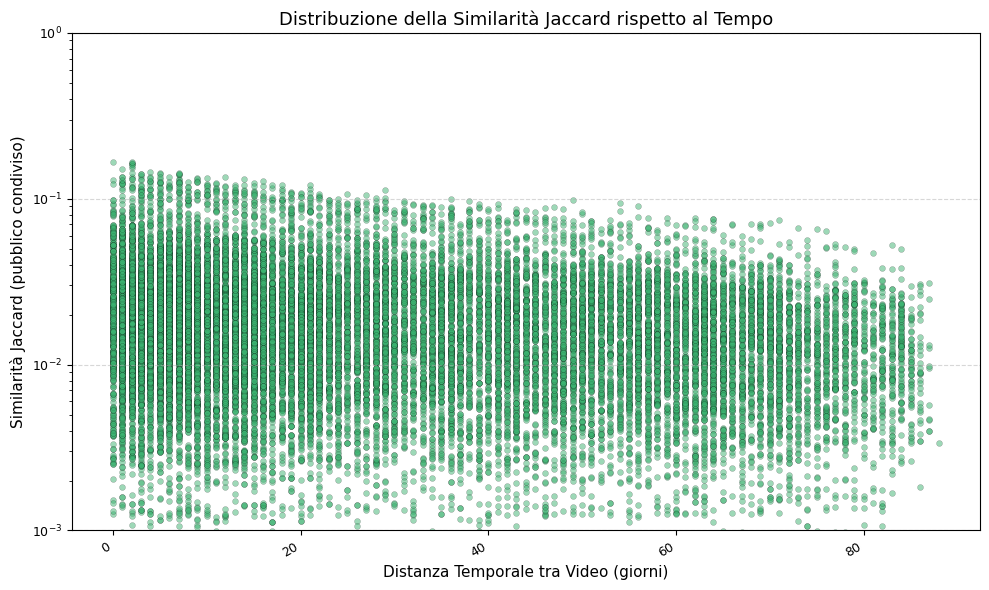

In [82]:
# Calcolo della correlazione tra similarità Jaccard e differenza temporale
jaccard_similarities = []
time_differences = []
view_diffs = []

for node1, node2, data in video_video_G.edges(data=True):
    commenters1 = Commenters_of_video.get(node1, set())
    commenters2 = Commenters_of_video.get(node2, set())

    intersection = len(commenters1.intersection(commenters2))
    union = len(commenters1.union(commenters2))
    jaccard = intersection / union if union > 0 else 0

    date1 = datetime.fromisoformat(Date_of_video.get(node1, "2025-01-01"))
    date2 = datetime.fromisoformat(Date_of_video.get(node2, "2025-01-01"))
    diff_days = abs((date1 - date2).days)

    views1 = Video_to_views.get(node1, 0)
    views2 = Video_to_views.get(node2, 0)
    view_diff = abs(views1 - views2)

    jaccard_similarities.append(jaccard)
    time_differences.append(diff_days)
    view_diffs.append(view_diff)

# Correlazione Spearman
correlation, p_value = spearmanr(jaccard_similarities, time_differences)

print(f"\n=== Correlazione Jaccard vs Differenza Temporale ===")
print(f"ρ = {correlation:.4f}, p-value = {p_value:.6f}")
print(f"Media diff giorni: {np.mean(time_differences):.2f}, max: {np.max(time_differences)}")

print(f"\n=== Statistiche Similarità Jaccard ===")
print(f"Media: {np.mean(jaccard_similarities):.4f}")
print(f"Mediana: {np.median(jaccard_similarities):.4f}")
print(f"Deviazione standard: {np.std(jaccard_similarities):.4f}")
print(f"Min: {np.min(jaccard_similarities):.4f}")
print(f"Max: {np.max(jaccard_similarities):.4f}")

print(f"\n=== Statistiche Differenza Temporale (giorni) ===")
print(f"Media: {np.mean(time_differences):.2f}")
print(f"Mediana: {np.median(time_differences):.2f}")
print(f"Deviazione standard: {np.std(time_differences):.2f}")
print(f"Min: {np.min(time_differences)}")
print(f"Max: {np.max(time_differences)}")

plt.figure(figsize=(10, 6))
plt.scatter(time_differences, jaccard_similarities, alpha=0.5, s=18, color='mediumseagreen', edgecolor='black', linewidth=0.2)
plt.xlabel("Distanza Temporale tra Video (giorni)", fontsize=11)
plt.ylabel("Similarità Jaccard (pubblico condiviso)", fontsize=11)
plt.title("Distribuzione della Similarità Jaccard rispetto al Tempo", fontsize=13)
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

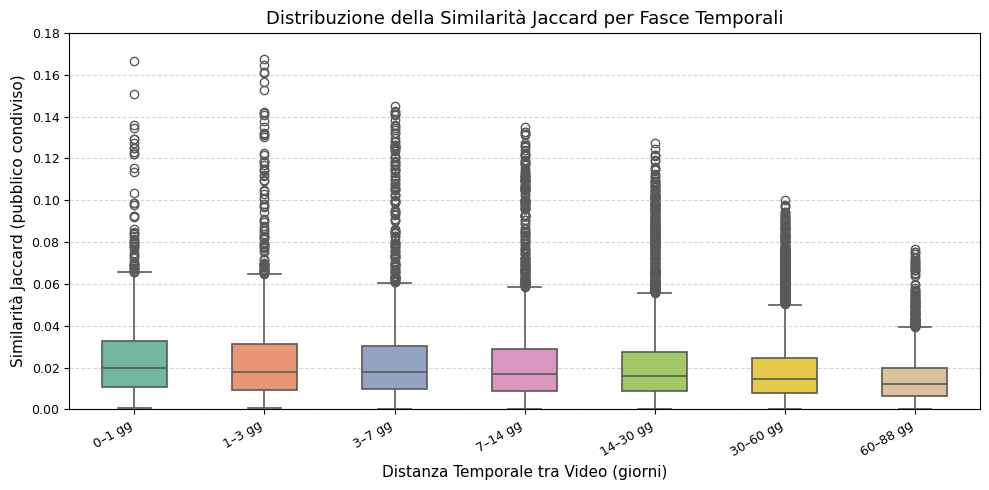


=== Statistiche per Bin Temporale ===
               mean    median       std       min       max  count
Tempo_Bin                                                         
0–1 gg     0.025129  0.019565  0.021246  0.000697  0.166667   1154
1–3 gg     0.025416  0.018076  0.024872  0.000678  0.167460   1190
3–7 gg     0.024046  0.017806  0.022208  0.000189  0.145172   2404
7–14 gg    0.022506  0.017009  0.020508  0.000378  0.134979   3467
14–30 gg   0.021607  0.016153  0.019122  0.000189  0.127534   5223
30–60 gg   0.018604  0.014374  0.015409  0.000377  0.100175   6592
60–88 gg   0.014391  0.012098  0.010689  0.000189  0.076784   3830


In [83]:
# Quanto influisce la distanza temporale tra due video sulla similarità del pubblico che li commenta?
df_inverse = pd.DataFrame({
    'Similarità Jaccard': jaccard_similarities,
    'Differenza Temporale (giorni)': time_differences
})

time_bins = [0, 1, 3, 7, 14, 30, 60, 88]
time_labels = [f"{time_bins[i]}–{time_bins[i+1]} gg" for i in range(len(time_bins)-1)]

df_inverse['Tempo_Bin'] = pd.cut(df_inverse['Differenza Temporale (giorni)'], bins=time_bins, labels=time_labels, include_lowest=True)
df_inverse.dropna(subset=['Tempo_Bin'], inplace=True)
df_inverse['Tempo_Bin'] = pd.Categorical(df_inverse['Tempo_Bin'], categories=time_labels, ordered=True)

plt.figure(figsize=(10, 5))  
sns.boxplot(
    x='Tempo_Bin',
    y='Similarità Jaccard',
    hue='Tempo_Bin',         
    data=df_inverse,
    palette='Set2',          
    showfliers=True,        
    width=0.5,               
    linewidth=1.2,
    legend=False             
)

plt.xlabel('Distanza Temporale tra Video (giorni)', fontsize=11)
plt.ylabel('Similarità Jaccard (pubblico condiviso)', fontsize=11)
plt.title('Distribuzione della Similarità Jaccard per Fasce Temporali', fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.ylim(0, 0.18)  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n=== Statistiche per Bin Temporale ===")
stats_by_time = df_inverse.groupby('Tempo_Bin', observed=True)['Similarità Jaccard'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(stats_by_time)
